In [ ]:
"""
========================================================
Author: Sevan Harootonian
Affiliation: Princeton University
========================================================
"""

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the preprocessed DataFrame
preprocessed = pd.read_pickle('data/preprocessed/exp1/preprocessed_exp1.pkl')

# Load the bonus dictionary
with open('data/preprocessed/exp1/bonus_exp1.pkl', 'rb') as f:
    bonus = pickle.load(f)

# Load the df_fits DataFrame
df_fits = pd.read_pickle('data/preprocessed/exp1/df_fits_exp1_fit_randchoose.pkl')


model_name_mapping = {
    "OBM": "Bayes Optimal Teacher",
    "NBM": "No Inv. Plan. Bayes Teacher",
    "POM": "Prior-only Bayes Teacher",
    "Level,Reward": "Reward & Depth Heuristic",    
    "Reward": "Reward Heuristic",
    "Level": "Depth Heuristic",
    "PathAvgUtility": "Path Avg. Utility",
    "Q-values": "Q-values",
}


# Replace model names in the dataframe
df_fits['model'] = df_fits['model'].replace(model_name_mapping)

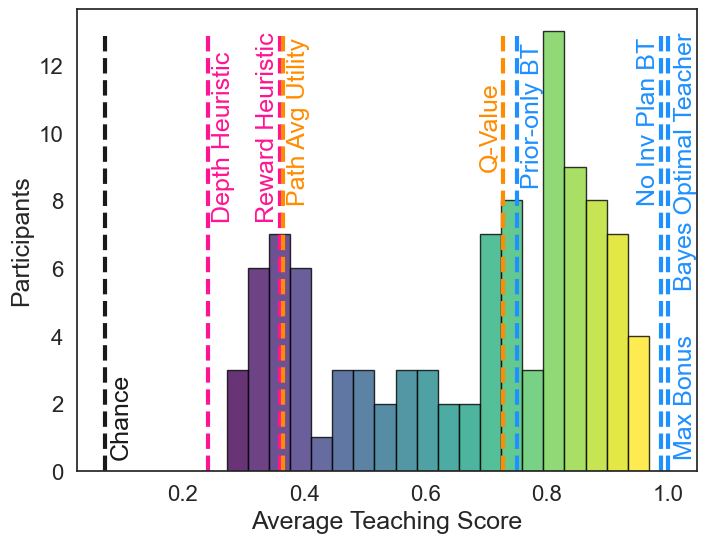

In [2]:
#results fig 2A
from functions.functions import max_value_keys

def get_mean_utility(trial,max_keys):
    temp_sum = 0
    if type(max_keys) == tuple:
        temp_sum = trial.OBM_AU[max_keys]
    else:
        for max_key in max_keys:
            temp_sum += trial.OBM_AU[max_key]
        temp_sum = temp_sum/len(max_keys)
    return temp_sum

seed_df = pd.DataFrame({'seed' : preprocessed.seed.unique()})
seed_df = pd.DataFrame({'seed': preprocessed.seed.unique(),
                        'Bayes Optimal Teacher': [preprocessed[preprocessed.seed == trial.seed].edge_max_U_obm.reset_index(drop=True)[0] for i, trial in seed_df.iterrows()]})

for i, row in seed_df.iterrows():
    trial = preprocessed[preprocessed.seed == row.seed].reset_index(drop=True).loc[0, :]
    max_reward_keys = max_value_keys(trial.feature_reward_sum)[0]
    max_level_keys = max_value_keys(trial.feature_levels, 'max')[0]
    min_level_keys = max_value_keys(trial.feature_levels, 'min')[0]
    max_NBM_keys = max_value_keys(trial.NBM_AU)[0]
    max_POM_keys = max_value_keys(trial.POM_AU)[0]
    max_Q_values_keys = max_value_keys(trial["Q-values"])[0]
    max_U_cond_keys = max_value_keys(trial.PathAvgUtility)[0]

    seed_df.loc[i, 'Reward Heuristic'] = get_mean_utility(trial, max_reward_keys)
    seed_df.loc[i, 'Depth Heuristic'] = get_mean_utility(trial, min_level_keys)
    seed_df.loc[i, 'No Inv Plan BT'] = get_mean_utility(trial, max_NBM_keys)
    seed_df.loc[i, 'Prior-only BT'] = get_mean_utility(trial, max_POM_keys)
    seed_df.loc[i, 'Q-Value'] = get_mean_utility(trial, max_Q_values_keys)
    seed_df.loc[i, 'Path Avg Utility'] = get_mean_utility(trial, max_U_cond_keys)

# Update model_perf dictionary
model_perf = {col: sum(seed_df[col]) * (6 / 5.33) / 20 for col in seed_df.columns if col != 'seed'}
model_perf.pop('Bayes Optimal Teacher')

# Update plot annotations
plt.figure(figsize=[8, 6])
sns.set(style="white")

max_bonus = 60
choices = 14
trials = 40
norm = max_bonus
chance = 1 / choices * max_bonus / norm
colors = plt.cm.viridis(np.linspace(0, 1, 20))
n, bins, patches = plt.hist(np.divide(list(bonus.values()), norm), bins=20, edgecolor='black', alpha=0.8)

# Apply the color map to the bars
for i, patch in enumerate(patches):
    patch.set_facecolor(colors[i])

plt.xlabel('Average Teaching Score', size=18)
plt.ylabel('Participants', size=18)
plt.xticks(size=16)
plt.yticks(size=16)
plt.vlines(x=max_bonus / norm, ymin=0, ymax=13, color='dodgerblue', linewidth=3, linestyle='--')
plt.vlines(x=1 / 14 * max_bonus / norm, ymin=0, ymax=13, color='k', linewidth=3, linestyle='--')
plt.annotate('Max Bonus', xy=(max_bonus / norm, 0), xytext=(60.5 / norm, .5), rotation=90, size=18, color='dodgerblue')
plt.annotate('Chance', xy=(chance, 0), xytext=(chance + .5 / norm, .5), rotation=90, size=18, color='k')
plt.annotate('Bayes Optimal Teacher', xy=(max_bonus/norm, 0), xytext=(60.5/norm, 5.5), rotation=90, size=18, color='dodgerblue')

norm2 = max_bonus / trials

# Update vline annotations for model_perf
for k, v in model_perf.items():
    b = 0
    if k in ['Depth Heuristic', 'Reward Heuristic']:
        color = 'deeppink'
        temp_y = 7.5
        if k == 'Reward Heuristic':
            b = -.07
    elif k in ['Q-Value', 'Path Avg Utility']:
        color = 'darkorange'
        temp_y = 8
        if k == 'Q-Value':
            b = -.07
            temp_y = 9
    elif k == 'No Inv Plan BT':
        color = 'dodgerblue'
        temp_y = 8
        b = -.07
    else:
        temp_y = 8.5
        color = 'dodgerblue'
    plt.vlines(x=v / norm2, ymin=0, ymax=13, color=color, linewidth=3, linestyle='--')
    plt.annotate(k, xy=(v / norm2, 0), xytext=((v + .01 + b) / norm2, temp_y), rotation=90, size=18, color=color)

C:\Users\skh\AppData\Local\Temp\ipykernel_26644\3670711769.py:17: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(
C:\Users\skh\AppData\Local\Temp\ipykernel_26644\3670711769.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)


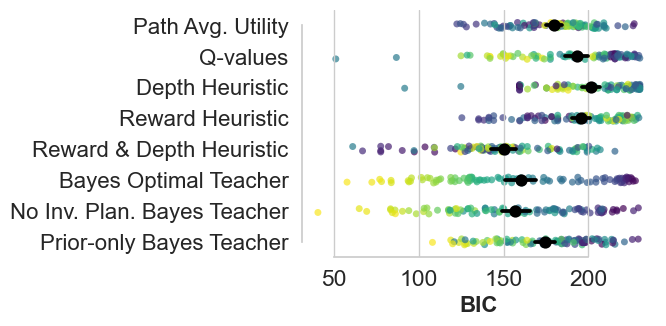

In [3]:
#results fig 2B

for i, row in df_fits.iterrows():
    df_fits.at[i, 'BIC'] = np.log(40) * row.nparam + 2 * row.nll
    df_fits.at[i, 'bonus'] = bonus[row.subjID]

models = df_fits.model.unique()
plotdf = df_fits[df_fits.model.isin(models)]
plotdf['avg_bonus'] = plotdf['bonus'] / 40  


sns.set(style="whitegrid", font_scale=1.5)
cmap = sns.color_palette("viridis", n_colors=100)

fig, ax = plt.subplots(figsize=(7, len(models) * 0.45))  # Adjusted height for compact y-axis

g = sns.pointplot(
    data=plotdf,
    y='model',
    x='BIC',
    color='black',
    errorbar=('ci', 95),
    estimator=np.mean,
    n_boot=1000,
    join=False,
    ax=ax
)

sns.stripplot(
    data=plotdf,
    y='model',
    x='BIC',
    hue='avg_bonus',
    palette=cmap,
    alpha=0.7,
    s=5,
    ax=ax,
    zorder=0,
)

if ax.get_legend() is not None:
    ax.legend_.remove()
    
ax.set_xlabel('BIC', fontsize=16, weight='bold')
ax.set_ylabel('')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
plt.tight_layout()
sns.despine(trim=True)
plt.show()


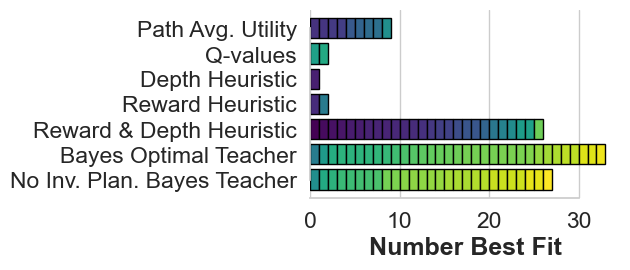

In [4]:
#results fig 2C

bestfitmodelnames = [plotdf.loc[plotdf['BIC'] == row.BIC, :].model.item() for i,row in plotdf.groupby('subjID').BIC.min().reset_index().iterrows()]

testdf = pd.DataFrame()
for i in range(len(plotdf.subjID.unique())):
    subjID = plotdf.subjID.unique()[i]
    testdf.at[i, 'subjID'] = subjID
    testdf.at[i, 'bonus'] = plotdf[plotdf.subjID == subjID].bonus.tolist()[0]

# Initialize the new column for best fit model by at least 10%
testdf['best fit model 10%'] = 'ΔBIC<10'

# Calculate the 10% threshold for each subject
for i in range(len(testdf)):
    subjID = testdf.at[i, 'subjID']
    subj_data = plotdf[plotdf.subjID == subjID]
    min_bic = subj_data['BIC'].min()
    threshold = min_bic + 0
    better_models = subj_data[subj_data['BIC'] <= threshold]
    
    if len(better_models) == 1:
        testdf.at[i, 'best fit model 10%'] = better_models['model'].item()
    elif len(better_models) > 1:
        best_model = better_models.iloc[0]['model']
        
        if (abs(better_models.iloc[0]['BIC'] - better_models.iloc[1]['BIC']) / better_models.iloc[0]['BIC']) >= 0.10:
            testdf.at[i, 'best fit model 10%'] = best_model

sns.set(style="whitegrid", font_scale=1.5)
bestfitcounts = testdf['best fit model 10%'].value_counts().reset_index()
bestfitcounts.columns = ['model', 'count']

# Ensure "inconclusive" is at the bottom
inconclusive_count = bestfitcounts[bestfitcounts['model'] == 'ΔBIC<10']
bestfitcounts = bestfitcounts[bestfitcounts['model'] != 'ΔBIC<10']
bestfitcounts = bestfitcounts.sort_values(by='count', ascending=False)
if not inconclusive_count.empty:
    bestfitcounts = pd.concat([bestfitcounts, inconclusive_count])

# Normalize the bonus values by dividing by 40
testdf['normalized_bonus'] = testdf['bonus'] / 40

# Define colors for different sections of the bars
colors = sns.color_palette("viridis", n_colors=20)

# Initialize a color map for the normalized bonus values
cmap = sns.color_palette("viridis", as_cmap=True)
norm = plt.Normalize(testdf['normalized_bonus'].min(), testdf['normalized_bonus'].max())


# Prepare data for plotting
plot_data = []
for model in bestfitcounts['model']:
    model_data = testdf[testdf['best fit model 10%'] == model]
    model_data = model_data.sort_values('normalized_bonus')  # Sort by normalized bonus to apply colors
    count = len(model_data)
    sections = model_data['normalized_bonus']
    colors_sections = [cmap(norm(bonus)) for bonus in sections]
    for i, b in enumerate(sections):
        plot_data.append([model, 1, colors_sections[i]])  # each count as 1 for stacking

plot_data_df = pd.DataFrame(plot_data, columns=['model', 'count', 'color'])

# Initialize bottom positions for the bars
bottom = {model: 0 for model in bestfitcounts['model']}

# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize=(4, len(bestfitcounts['model']) * 0.35))  # Adjusted height for compact y-axis

# Adjust the order of models in the plot
# models_ordered = bestfitcounts['model'].values

models_ordered = [
    'Prior-only Bayes Teacher',
    'No Inv. Plan. Bayes Teacher',
    'Bayes Optimal Teacher',
    'Reward & Depth Heuristic',
    'Reward Heuristic',
    'Depth Heuristic',                   
    'Q-values',
    'Path Avg. Utility',
]
plot_data_df['model'] = pd.Categorical(plot_data_df['model'], categories=models_ordered, ordered=True)

for model in models_ordered[::1]:
    model_data = plot_data_df[plot_data_df['model'] == model]
    for idx, row in model_data.iterrows():
        ax.barh(row['model'], row['count'], left=bottom[row['model']], color=row['color'], edgecolor='black')
        bottom[row['model']] += row['count']

# Customize ticks and labels with larger font size
ax.set_xlabel('Number Best Fit', fontsize=18, weight='bold')
ax.grid(True, axis='x')
ax.grid(False, axis='y')
sns.despine(trim=True)

# Show the plot
plt.show()

In [5]:
models_ordered

['Prior-only Bayes Teacher',
 'No Inv. Plan. Bayes Teacher',
 'Bayes Optimal Teacher',
 'Reward & Depth Heuristic',
 'Reward Heuristic',
 'Depth Heuristic',
 'Q-values',
 'Path Avg. Utility']

In [6]:
from scipy.stats import mannwhitneyu

# Extract the BIC values for the two models
bic_level_reward = plotdf[plotdf['model'] == 'Reward & Depth Heuristic'].BIC
bic_obm = plotdf[plotdf['model'] == 'Bayes Optimal Teacher'].BIC

# Perform Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(bic_level_reward, bic_obm)

print(f"Mann-Whitney U test statistic: {u_statistic}")
print(f"P-value: {p_value}")

Mann-Whitney U test statistic: 4410.0
P-value: 0.1497605554233568


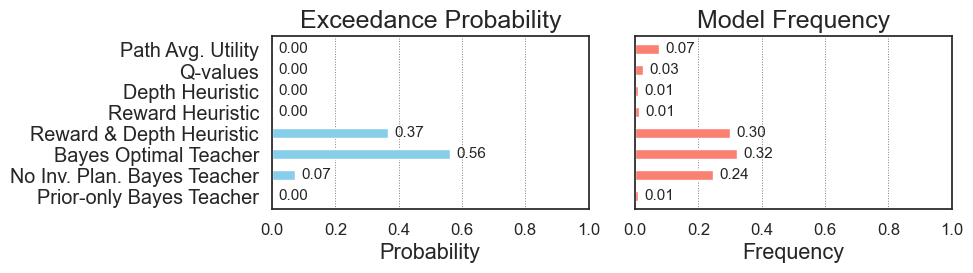

In [7]:
from functions.model_comparison import *

#convert to wide format
df_BIC = df_fits.pivot(index='subjID', columns='model', values='BIC').reset_index()

model_cols, r_std, alpha_std, u_std, log_ev, alpha0_std = vb_random_effects_model_comparison(df_BIC, alpha0_value=1.0)
_, _, alpha_null, u_null, _, alpha0_null = vb_random_effects_model_comparison(df_BIC, alpha0_value=1000.0)

L_std = compute_elbo(log_ev, u_std, alpha0_std, alpha_std)
L_null = compute_elbo(log_ev, u_null, alpha0_null, alpha_null)
phi = compute_exceedance(alpha_std)
P0 = 1 / (1 + np.exp(L_std - L_null))
K = len(model_cols)
tilde_phi = (1 - P0) * phi + P0 * (1.0 / K)

sns.set(style="white", font_scale=1.3)
model_order = [
    'Prior-only Bayes Teacher',
    'No Inv. Plan. Bayes Teacher',
    'Bayes Optimal Teacher',
    'Reward & Depth Heuristic',
    'Reward Heuristic',
    'Depth Heuristic',                   
    'Q-values',
    'Path Avg. Utility',
]

fig, axes = plot_model_comparison_horizontal(
    model_cols, r_std, phi,
    order=model_order, figsize=(10,3)
)
plt.show()

In [ ]:
simdata = pd.DataFrame(pd.read_pickle('data/sim/exp1/exp1_modelsim.pickle'))
rename_simdata_map = {
    "PathAvgUtility": 'Path Avg Utility',
    "feature_levels": "Depth Heuristic",
    "feature_reward_sum": "Reward Heuristic",
    "OBM_AU": "Bayes Optimal Teacher",
    "NBM_AU": "No Inv. Plan. Bayes Teacher",
    "POM_AU": "Prior-only Bayes Teacher",
}
simdata.rename(columns=rename_simdata_map, inplace=True)

# Load and combine the split posterior simulation files (split to reduce file size for GitHub)
posterior_sim_0to50 = pd.read_pickle("data/sim/exp1/exp1_posterior_sim_0to50.pkl")
posterior_sim_50to100 = pd.read_pickle("data/sim/exp1/exp1_posterior_sim_50to100.pkl")
posterior_sim = pd.concat([posterior_sim_0to50, posterior_sim_50to100], ignore_index=True)

rename_posterior_sim_map = {
    "Q-values": "Q-values",
    "PathAvgUtility": 'Path Avg. Utility',
    "Level": "Depth Heuristic",
    "Reward": "Reward Heuristic",
    'Level,Reward': 'Reward & Depth Heuristic',
    "OBM": "Bayes Optimal Teacher",
    "NBM": "No Inv. Plan. Bayes Teacher",
    "POM": "Prior-only Bayes Teacher",
}
posterior_sim['sim_model'] = posterior_sim['sim_model'].replace(rename_posterior_sim_map)

sim_fits = pd.read_pickle("data/sim/exp1/exp1_simfits_100.pkl")
sim_fits['sim_model'] = sim_fits['sim_model'].replace(rename_posterior_sim_map)
sim_fits['fit_model'] = sim_fits['fit_model'].replace(rename_posterior_sim_map)

# Find the row index with the min BIC per subjID
idx = df_fits.groupby("subjID")["BIC"].idxmin()

# Use those indices to get the rows
best_models = df_fits.loc[idx].reset_index(drop=True)

merged = posterior_sim.merge(
    best_models,
    left_on=["subjID", "sim_model"],
    right_on=["subjID", "model"],
    how="inner"
)

best_models.groupby('model').BIC.size()

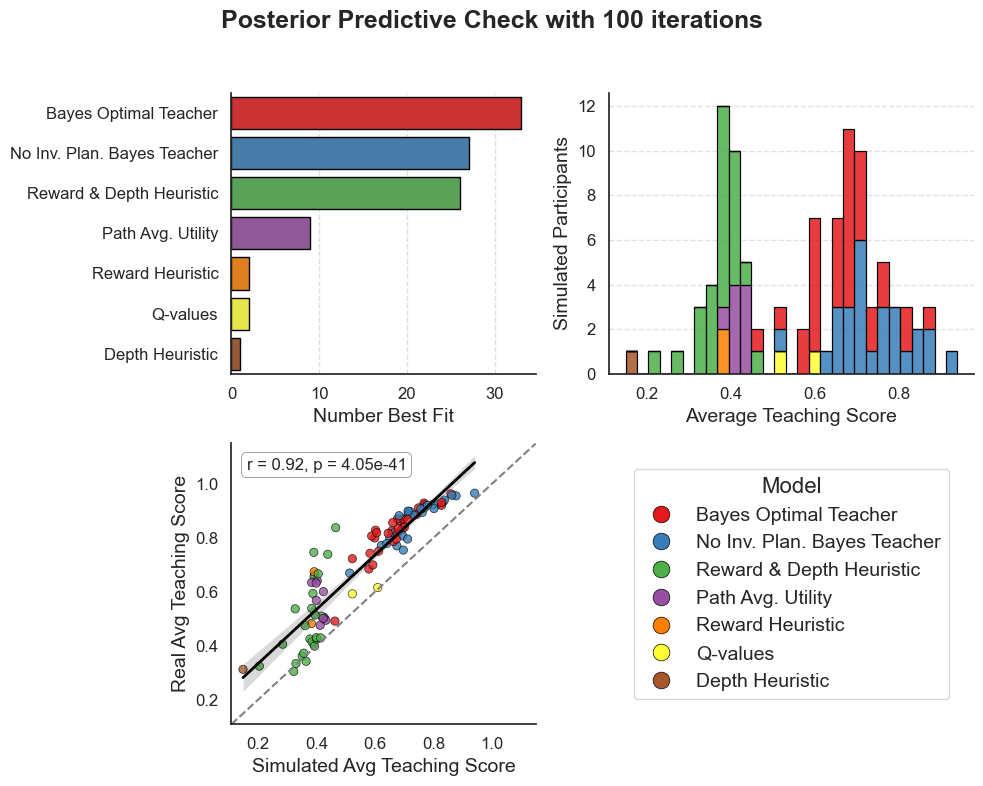

In [13]:
import importlib, functions.model_comparison
importlib.reload(functions.model_comparison)
from functions.model_comparison import *

per_subj, counts_df, model_order, model_palette = prepare_ppc_data(best_models, merged)

real_df = preprocessed.loc[:,['subjID', 'edge_normresp_U_obm']]
fig, axes = plot_bestfit_ppc_corr(per_subj, counts_df, model_order, model_palette,
                                  real_df=real_df, real_score_col="edge_normresp_U_obm",
                                  iter_count=merged["iteration"].nunique(),
                                  figsize=(10,8))
plt.show()

Overall recovery (diagonal) = 0.731  [58509/80000]


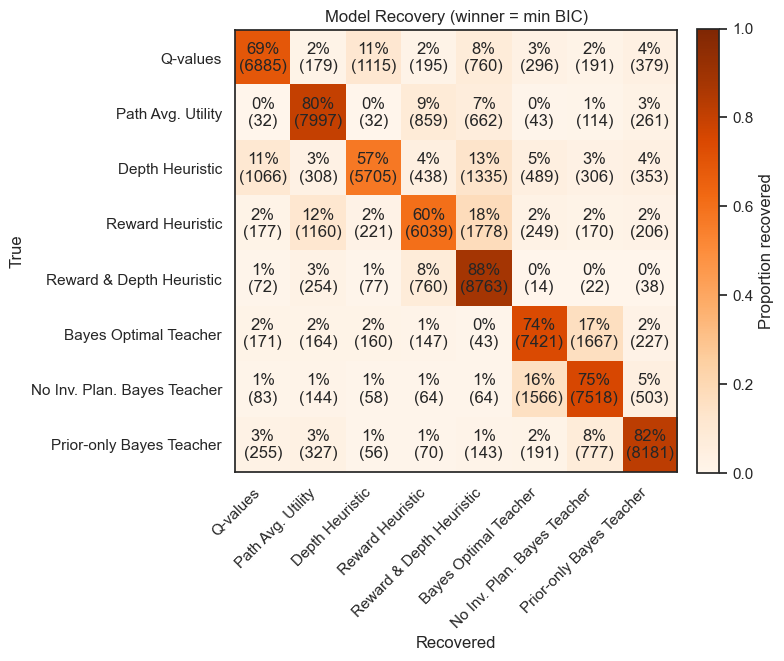

In [14]:
model_order = [
    "Q-values",
    "Path Avg. Utility",
    "Depth Heuristic",
    "Reward Heuristic",
    "Reward & Depth Heuristic",
    "Bayes Optimal Teacher",
    "No Inv. Plan. Bayes Teacher",
    "Prior-only Bayes Teacher",
]
counts, props, fig = model_recovery_plot(sim_fits, metric="BIC", order=model_order)

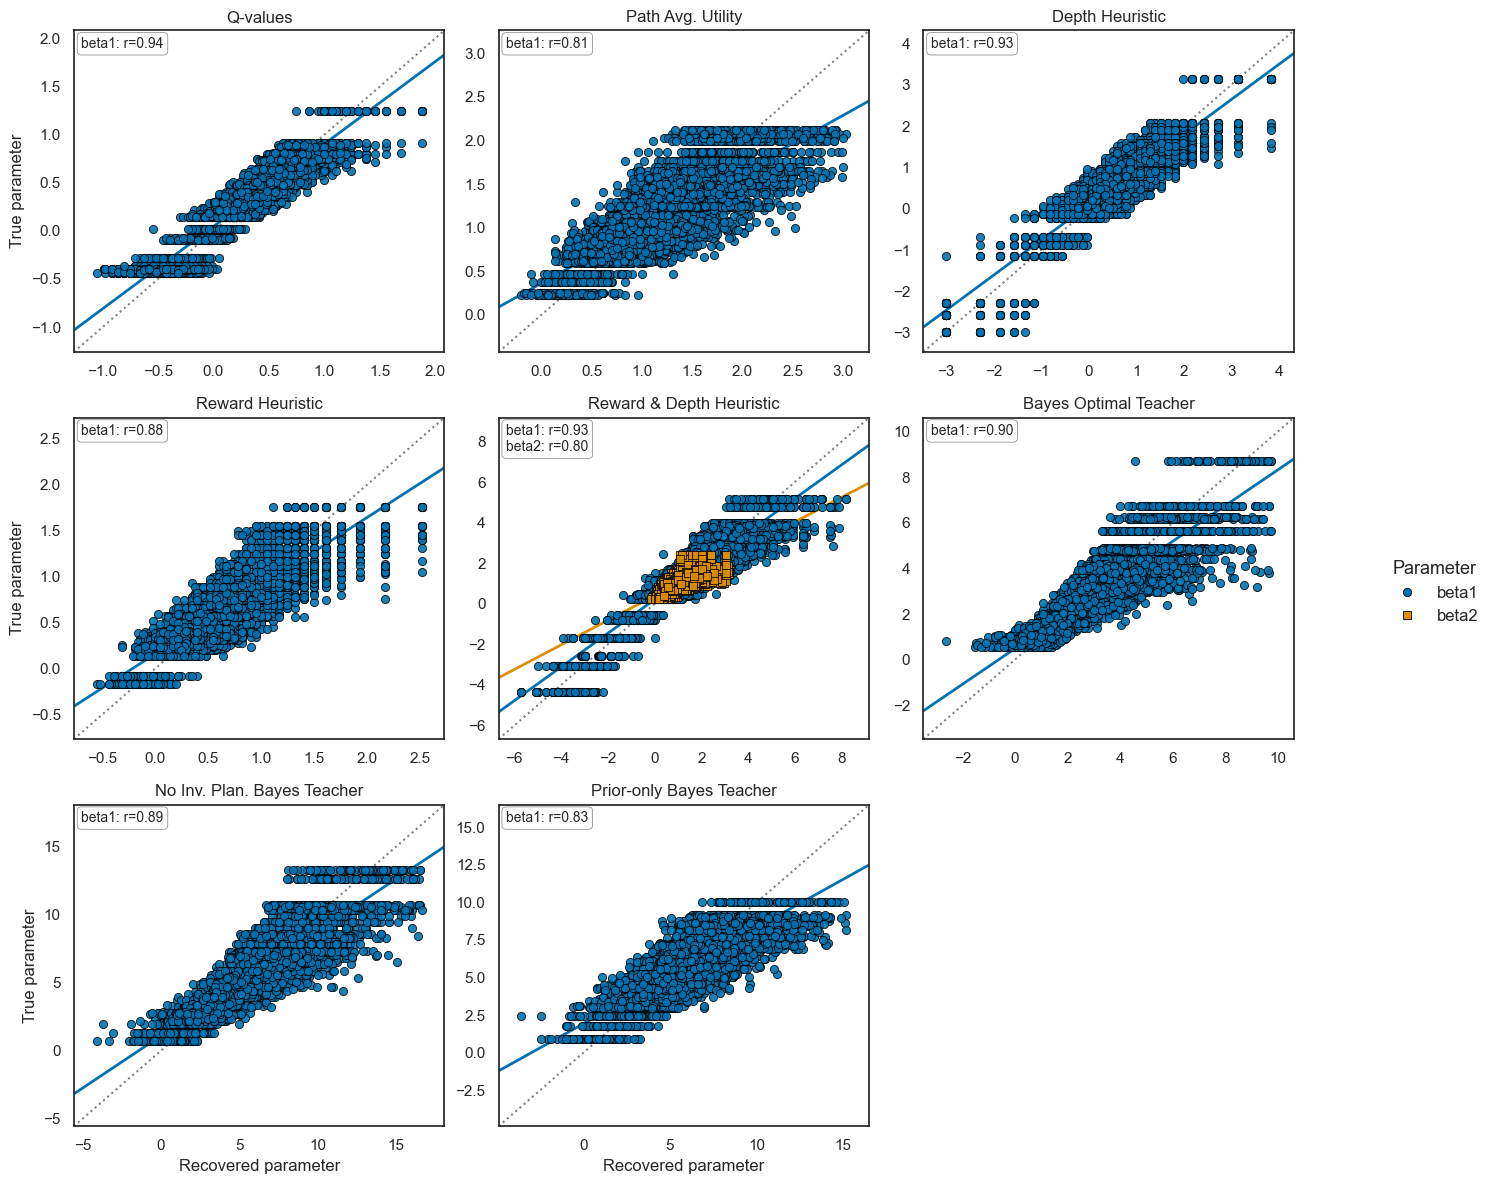

In [15]:
param_long = build_param_recovery_long(true_df=df_fits,  # your “true betas” df
                                       sim_fits_all=sim_fits)
param_long_plot = filter_param_outliers(
    param_long,
    method="mad",        # robust default
    mad_thresh=4.5,      # slightly stricter than 4.0; adjust as you like
    iqr_k=3.0            # 'extreme' Tukey fence fallback
)

fig, axes = plot_param_recovery_grid(
    param_long_plot,
    model_order=[
        "Q-values", "Path Avg. Utility", "Depth Heuristic", "Reward Heuristic",
        "Reward & Depth Heuristic", "Bayes Optimal Teacher", "No Inv. Plan. Bayes Teacher", "Prior-only Bayes Teacher"
    ],
    ncols=3,
    pad=0.07,
    clip_quantiles=None,         # or (0.01, 0.99) if needed
    # model_title_map=model_title_map
)
plt.show()
